In [25]:
# -*- coding: utf-8 -*-

"""
Created on Tue Feb 11 09:25:53 2025

@author: JVJ
"""

#%load_ext autoreload
#%autoreload 2

from WealthChannelsModel import WealthBehaviorModelClass
import numpy as np
import sympy
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams.update({
    "axes.grid": True,
    "grid.color": "black",
    "grid.alpha": 0.25,
    "grid.linestyle": "--",
    "font.size": 14                    # Set font size
})
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
from EconDLSolvers import choose_gpu
import torch, gc
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

torch.cuda.empty_cache()

# Hyperparameters
device = choose_gpu()
model_DL = {}

# DeepSimulate
K_time = 2.0
model_DL[r'DeepSimulate: $\beta\in (0.95, 0.99)$'] = WealthBehaviorModelClass(algoname='DeepSimulate', par={'bequest': 1.0}, device=device,train={'K_time': K_time})
model_DL[r'DeepSimulate: $\beta\in (0.95, 0.99)$'].solve(do_print=True)

model_DL[r'DeepSimulate: $\beta = 0.99$'] = WealthBehaviorModelClass(algoname='DeepSimulate', par={'beta': 0.99},device=device,train={'K_time': K_time})
model_DL[r'DeepSimulate: $\beta = 0.99$'].solve(do_print=True)

model_DL[r'DeepSimulate: $\beta = 0.95$'] = WealthBehaviorModelClass(algoname='DeepSimulate',par={'beta': 0.95}, device=device,train={'K_time': K_time})
model_DL[r'DeepSimulate: $\beta = 0.95$'].solve(do_print=True)

#model_DL['DeepSimulate'].save('DeepSimulate_30M_target_inflation.pkl')

# DeepVPD
K_time = 5.0
model_DL[r'DeepVPD: $\beta\in (0.95, 0.99)$'] = WealthBehaviorModelClass(algoname='DeepVPD', device=device,train={'K_time': K_time})
model_DL[r'DeepVPD: $\beta\in (0.95, 0.99)$'].solve(do_print=True)

#model_DL['DeepVPD'].save('DeepVPD_30M_target_inflation.pkl')

#K_time = 5.0
#model_DL['DeepFOC'] = WealthBehaviorModelClass(algoname='DeepFOC',par={'KKT': True}, device=device,train={'K_time': K_time})
#model_DL['DeepFOC'].solve(do_print=True)

#model_DL['DeepVPD'].save('DeepFOC_5M_target_inflation.pkl')

GPU 0: 75.21GB free
Best GPU: 0
started solving: 2025-04-07 16:36:01
k =     0 of inf: sim.R = -489433.40625000 [best: -489433.40625000] [0.7 secs] [value_epochs =   0] [policy_epochs =   1] [  0.01 mins]
k =    50 of inf: sim.R = -252383.06250000 [best: -252383.06250000] [0.6 secs] [value_epochs =   0] [policy_epochs =   1] [  0.27 mins]
k =   100 of inf: sim.R = -96131.33593750 [best: -96131.33593750] [0.6 secs] [value_epochs =   0] [policy_epochs =   1] [  0.53 mins]
k =   150 of inf: sim.R = -59514.97656250 [best: -59514.97656250] [0.6 secs] [value_epochs =   0] [policy_epochs =   1] [  0.79 mins]
k =   200 of inf: sim.R = -80196.03125000 [best: -59514.97656250] [0.6 secs] [value_epochs =   0] [policy_epochs =   1] [  1.05 mins] no improvements in 0.3 mins
k =   250 of inf: sim.R = -319056.68750000 [best: -59514.97656250] [0.7 secs] [value_epochs =   0] [policy_epochs =   1] [  1.31 mins] no improvements in 0.5 mins
k =   300 of inf: sim.R = -209332.82812500 [best: -59514.97656250]

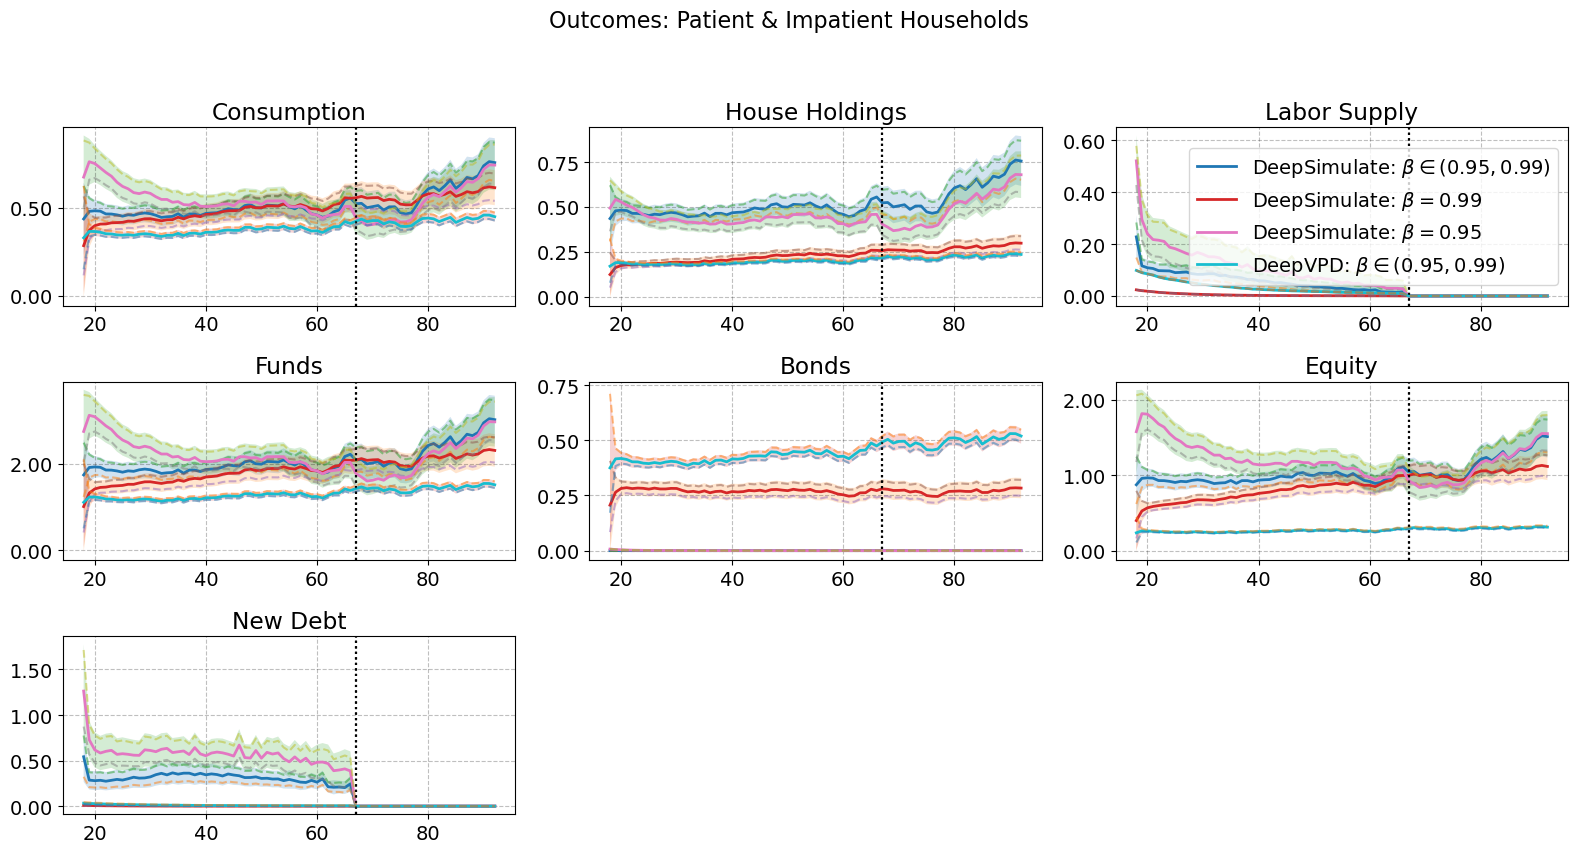

In [26]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

figs, axes = plt.subplots(3, 3, figsize=(16, 9))
axes = axes.flatten()

titles = [
    'Consumption',        # 0
    'House Holdings',     # 1
    'Labor Supply',       # 2
    'Funds',              # 3
    'Bonds',              # 4
    'Equity',             # 5
    'New Debt'            # 6
]

# Map each variable index to a subplot index
var_to_ax = {
    0: 0,  # Consumption
    1: 1,  # House Holdings
    2: 2,  # Labor Supply
    3: 3,  # Funds
    4: 4,  # Bonds
    5: 5,  # Equity
    6: 6   # New Debt
}

for model_key, model_obj in model_DL.items():
    outcomes = model_obj.sim.outcomes.cpu().numpy()

    for var_index, ax_index in var_to_ax.items():
        data = outcomes[:, :, var_index]
        mean_series = np.mean(data, axis=1)
        std_series = np.std(data, axis=1)
        p5 = np.percentile(data, 5, axis=1)
        p95 = np.percentile(data, 95, axis=1)

        age_grid = np.arange(data.shape[0]) + 18  # Start from age 18

        # Plot mean
        axes[ax_index].plot(age_grid, mean_series, label=model_key, lw=2)

        # 95% confidence band
        axes[ax_index].fill_between(age_grid,
                                    mean_series - 2 * std_series,
                                    mean_series + 2 * std_series,
                                    alpha=0.2)

        # 5th and 95th percentiles
        axes[ax_index].plot(age_grid, p5, linestyle='--', alpha=0.5)
        axes[ax_index].plot(age_grid, p95, linestyle='--', alpha=0.5)

        # Add vertical line at retirement age = 18 + T_retired (e.g., 49)
        axes[ax_index].axvline(x=67, linestyle=':', color='black', alpha=0.7)

# Set subplot titles
for idx, title in enumerate(titles):
    axes[idx].set_title(title)

# Format y-axis
for ax in axes.flat:
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

# Hide unused subplots
for idx in range(7, 9):
    axes[idx].axis('off')

# Place legend outside the first axis
axes[2].legend(loc='center right') #, bbox_to_anchor=(1.0, 0.5))

figs.suptitle("Outcomes: Patient & Impatient Households", fontsize=16)
figs.tight_layout(rect=[0, 0.03, 1, 0.95])
figs.savefig("Outcomes_Households_TARGET_INFLATION.png", dpi=300)
plt.show()


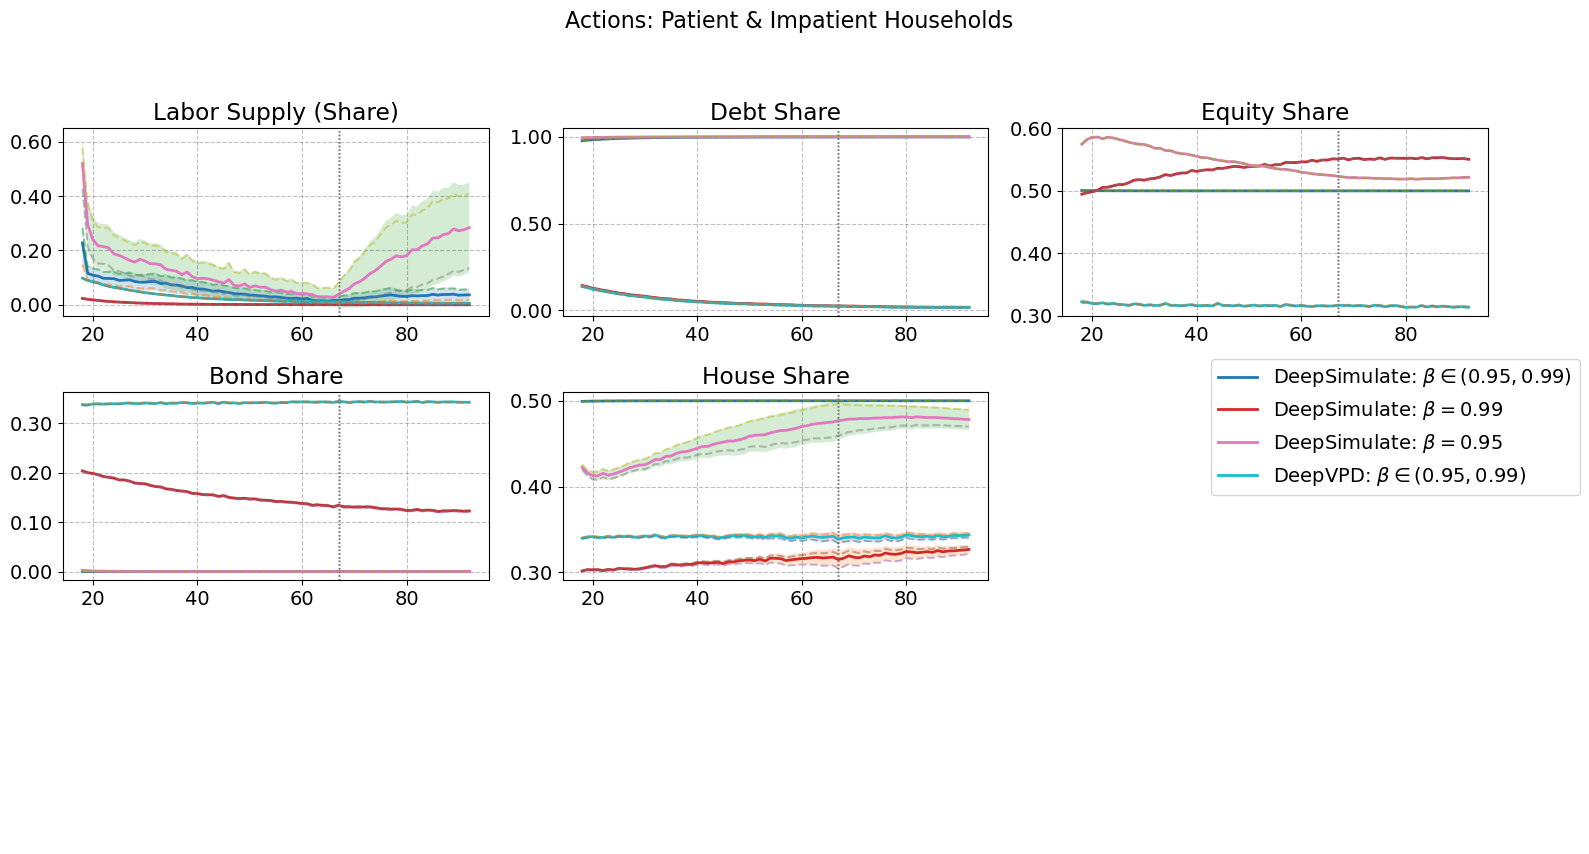

In [27]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

figs, axes = plt.subplots(3, 3, figsize=(16, 9))
axes = axes.flatten()

titles = [
    'Labor Supply (Share)',   # 0
    'Debt Share',             # 1
    'Equity Share',           # 2
    'Bond Share',             # 3
    'House Share'             # 4
]

# Variable to subplot mapping
var_to_ax = {
    0: 0,  # Labor supply
    1: 1,  # Debt
    2: 2,  # Equity
    3: 3,  # Bonds
    4: 4   # House
}

age_start = 18
x = None  # Placeholder

for model_key, label in model_DL.items():
    actions = model_DL[model_key].sim.actions.cpu().numpy()
    T = actions.shape[0]
    x = np.arange(age_start, age_start + T)

    for var_index, ax_index in var_to_ax.items():
        ax = axes[ax_index]

        if var_index >= 2:
            total_asset = np.mean(actions[:, :, 2] + actions[:, :, 3] + actions[:, :, 4], axis=1, keepdims=True)
            data = actions[:, :, var_index] / total_asset
        else:
            data = actions[:, :, var_index]

        mean_series = np.mean(data, axis=1)
        std_series = np.std(data, axis=1)
        p5 = np.percentile(data, 5, axis=1)
        p95 = np.percentile(data, 95, axis=1)

        ax.plot(x, mean_series, label=model_key, lw=2)
        ax.fill_between(x, mean_series - 2 * std_series, mean_series + 2 * std_series, alpha=0.2)
        ax.plot(x, p5, linestyle='--', alpha=0.5)
        ax.plot(x, p95, linestyle='--', alpha=0.5)

        # Vertical line at retirement age (T = 49 → Age 67)
        ax.axvline(age_start + 49, color='gray', linestyle=':', linewidth=1)

# Set subplot titles
for idx, title in enumerate(titles):
    axes[idx].set_title(title)

# Format y-axis
for ax in axes:
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

# Hide unused subplots
for idx in range(5, 9):
    axes[idx].axis('off')

# Add legend outside the grid
handles, labels = axes[0].get_legend_handles_labels()
figs.legend(handles, labels, loc='center right') #, bbox_to_anchor=(1.01, 0.5))

# Final layout
figs.suptitle("Actions: Patient & Impatient Households", fontsize=16)
figs.tight_layout(rect=[0, 0.03, 0.95, 0.95])  # reduced width for external legend
figs.savefig("Actions_Households_TARGET_INFLATION.png", dpi=300)
plt.show()


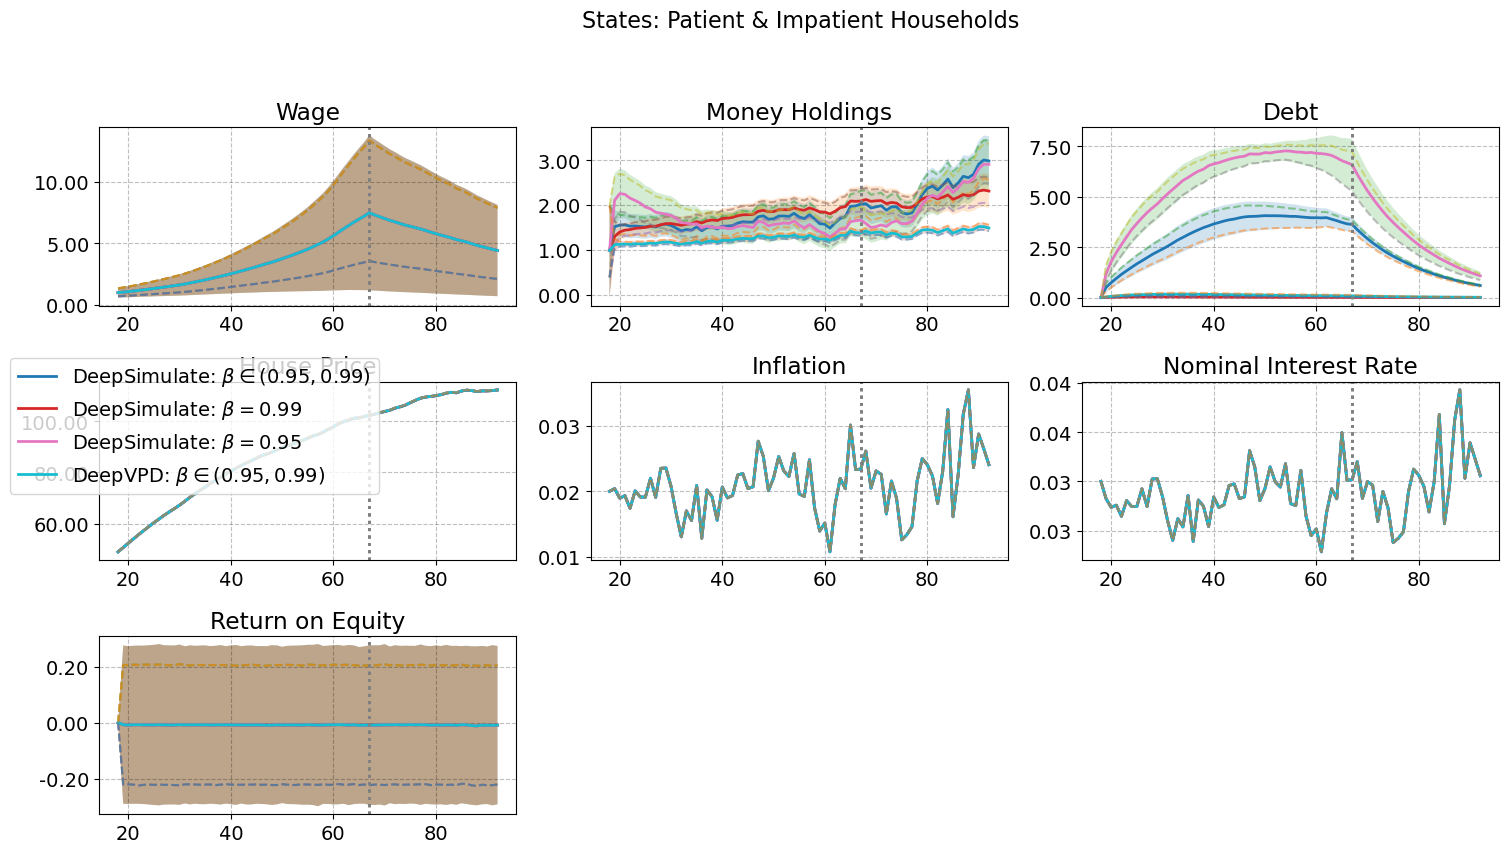

In [28]:
figs, axes = plt.subplots(3, 3, figsize=(16, 9))
axes = axes.flatten()

titles = [
    'Wage',                 # 0
    'Money Holdings',       # 1
    'Debt',                 # 2
    'House Price',          # 3
    'Inflation',            # 4
    'Nominal Interest Rate',# 5
    'Return on Equity'      # 6
]

var_to_ax = {
    0: 0,  # Wage
    1: 1,  # Money
    2: 2,  # Debt
    3: 3,  # House Price
    4: 4,  # Inflation
    5: 5,  # Interest Rate
    6: 6   # Return on Equity
}

age_start = 18
for model_key, label in model_DL.items():
    states = model_DL[model_key].sim.states.cpu().numpy()
    T = states.shape[0]
    x = np.arange(age_start, age_start + T)

    for var_index, ax_index in var_to_ax.items():
        ax = axes[ax_index]

        data = states[:, :, var_index]
        mean_series = np.mean(data, axis=1)
        std_series = np.std(data, axis=1)
        p5 = np.percentile(data, 5, axis=1)
        p95 = np.percentile(data, 95, axis=1)

        # Plotting
        ax.plot(x, mean_series, label=model_key, lw=2)
        ax.fill_between(x, mean_series - 2 * std_series, mean_series + 2 * std_series, alpha=0.2)
        ax.plot(x, p5, linestyle='--', alpha=0.5)
        ax.plot(x, p95, linestyle='--', alpha=0.5)

        # Retirement line at T=49 (age 67)
        ax.axvline(age_start + 49, color='gray', linestyle=':', linewidth=2)

# Set subplot titles and format
for idx, title in enumerate(titles):
    axes[idx].set_title(title)
    axes[idx].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

# Hide unused axes
for idx in range(7, 9):
    axes[idx].axis('off')

# Global legend outside
handles, labels = axes[0].get_legend_handles_labels()
figs.legend(handles, labels, loc='center left') #, bbox_to_anchor=(1.01, 0.5))

# Final layout
figs.suptitle("States: Patient & Impatient Households", fontsize=16)
figs.tight_layout(rect=[0, 0.03, 0.95, 0.95])
figs.savefig("States_Households_TARGET_INFLATION.png", dpi=300)
plt.show()

In [ ]:
# Distributional Plots

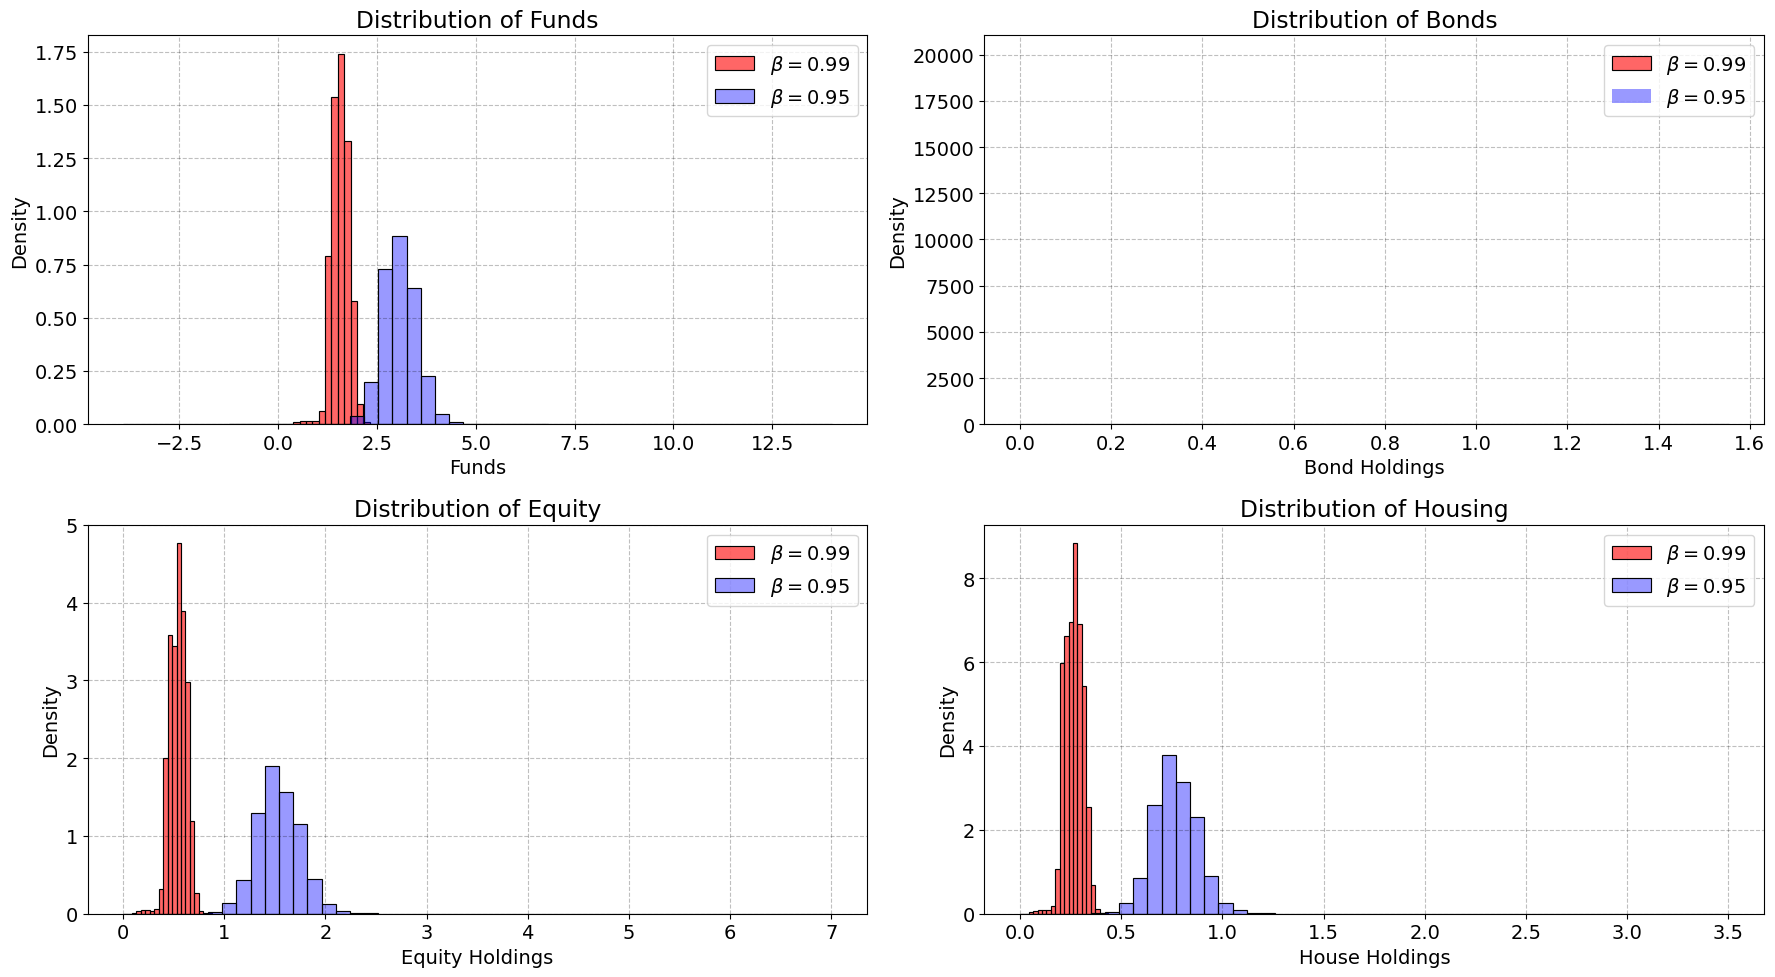

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract simulation outcomes
outcomes_high = model_DL[r'DeepSimulate: $\beta = 0.99$'].sim.outcomes.cpu().numpy()
outcomes_low = model_DL[r'DeepSimulate: $\beta = 0.95$'].sim.outcomes.cpu().numpy()

# Flatten the relevant variables
housing_high = outcomes_high[:, :, 1].flatten()
funds_high = outcomes_high[:, :, 3].flatten()
bonds_high = outcomes_high[:, :, 4].flatten()
equity_high = outcomes_high[:, :, 5].flatten()

housing_low = outcomes_low[:, :, 1].flatten()
funds_low = outcomes_low[:, :, 3].flatten()
bonds_low = outcomes_low[:, :, 4].flatten()
equity_low = outcomes_low[:, :, 5].flatten()

# Plot
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

# --- Funds ---
sns.histplot(funds_high, bins=50, stat='density', kde=False, ax=axs[0, 0], color='red', label=r'$\beta = 0.99$', alpha=0.6)
sns.histplot(funds_low, bins=50, stat='density', kde=False, ax=axs[0, 0], color='blue', label=r'$\beta = 0.95$', alpha=0.4)
axs[0, 0].set_title('Distribution of Funds')
axs[0, 0].set_xlabel('Funds')
axs[0, 0].legend()

# --- Bonds ---
sns.histplot(bonds_high, bins=50, stat='density', kde=False, ax=axs[0, 1], color='red', label=r'$\beta = 0.99$', alpha=0.6)
sns.histplot(bonds_low, bins=50, stat='density', kde=False, ax=axs[0, 1], color='blue', label=r'$\beta = 0.95$', alpha=0.4)
axs[0, 1].set_title('Distribution of Bonds')
axs[0, 1].set_xlabel('Bond Holdings')
axs[0, 1].legend()

# --- Equity ---
sns.histplot(equity_high, bins=50, stat='density', kde=False, ax=axs[1, 0], color='red', label=r'$\beta = 0.99$', alpha=0.6)
sns.histplot(equity_low, bins=50, stat='density', kde=False, ax=axs[1, 0], color='blue', label=r'$\beta = 0.95$', alpha=0.4)
axs[1, 0].set_title('Distribution of Equity')
axs[1, 0].set_xlabel('Equity Holdings')
axs[1, 0].legend()

# --- Housing ---
sns.histplot(housing_high, bins=50, stat='density', kde=False, ax=axs[1, 1], color='red', label=r'$\beta = 0.99$', alpha=0.6)
sns.histplot(housing_low, bins=50, stat='density', kde=False, ax=axs[1, 1], color='blue', label=r'$\beta = 0.95$', alpha=0.4)
axs[1, 1].set_title('Distribution of Housing')
axs[1, 1].set_xlabel('House Holdings')
axs[1, 1].legend()

plt.tight_layout()
fig.savefig("Wealth_Distribution_Households_TARGET_INFLATION.png", dpi=300)
plt.show()


In [12]:
import numpy as np
import matplotlib.pyplot as plt

states_high = model_DL[r'DeepSimulate: $\beta = 0.99$'].sim.states.cpu().numpy()
states_low = model_DL[r'DeepSimulate: $\beta = 0.95$'].sim.states.cpu().numpy()


# Extract variables from states and outcomes
housing_high = outcomes_high[:, :, 1]
funds_high   = outcomes_high[:, :, 3]
bonds_high   = outcomes_high[:, :, 4]
equity_high  = outcomes_high[:, :, 5]
wage_high    = states_high[:, :, 0]
money_high   = states_high[:, :, 1]
debt_high    = states_high[:, :, 2]

housing_low = outcomes_low[:, :, 1]
funds_low   = outcomes_low[:, :, 3]
bonds_low   = outcomes_low[:, :, 4]
equity_low  = outcomes_low[:, :, 5]
wage_low    = states_low[:, :, 0]
money_low   = states_low[:, :, 1]
debt_low    = states_low[:, :, 2]

# Age group bins (T = 75, starts at 18 → ages 18 to 93)
age_bins = {
    "18–34": np.arange(0, 17),
    "35–49": np.arange(17, 32),
    "50–64": np.arange(32, 47),
    "65–74": np.arange(47, 57),
    "75–84": np.arange(57, 67),
    "85+":   np.arange(67, 75)
}
labels = list(age_bins.keys())

def bin_data(var, bins):
    return [var[bins[label]].flatten() for label in labels]

# Bin each variable
data_high = [
    bin_data(housing_high, age_bins),
    bin_data(funds_high, age_bins),
    bin_data(bonds_high, age_bins),
    bin_data(equity_high, age_bins),
    bin_data(wage_high, age_bins),
    bin_data(money_high, age_bins),
    bin_data(debt_high, age_bins),
]

data_low = [
    bin_data(housing_low, age_bins),
    bin_data(funds_low, age_bins),
    bin_data(bonds_low, age_bins),
    bin_data(equity_low, age_bins),
    bin_data(wage_low, age_bins),
    bin_data(money_low, age_bins),
    bin_data(debt_low, age_bins),
]

titles = ["House Holdings", "Funds", "Bonds", "Equity", "Wages", "Money Holdings", "Debt"]

# Plot
fig, axs = plt.subplots(3, 3, figsize=(18, 12))
axs = axs.flatten()
colors = ["#ff9999", "#66b3ff"]  # High and low beta colors

positions_high = np.arange(len(labels)) - 0.2
positions_low  = np.arange(len(labels)) + 0.2

for i, ax in enumerate(axs[:len(titles)]):
    bp_high = ax.boxplot(data_high[i], positions=positions_high, widths=0.35, patch_artist=True,
                         boxprops=dict(facecolor=colors[0], alpha=0.6), tick_labels=labels)
    bp_low = ax.boxplot(data_low[i], positions=positions_low, widths=0.35, patch_artist=True,
                        boxprops=dict(facecolor=colors[1], alpha=0.6), tick_labels=[""] * len(labels))

    ax.set_title(titles[i])
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45)
    if i % 3 == 0:
        ax.set_ylabel("Level")
    ax.legend([bp_high["boxes"][0], bp_low["boxes"][0]],
              [r"$\beta = 0.99$", r"$\beta = 0.95$"], loc="upper right")

# Hide empty subplots if fewer than 9
for j in range(len(titles), 9):
    axs[j].axis('off')

plt.tight_layout()
plt.savefig("Boxplot_all_variables_age_groups_Households_TARGET_INFLATION.png", dpi=300)
plt.show()


NameError: name 'outcomes_high' is not defined

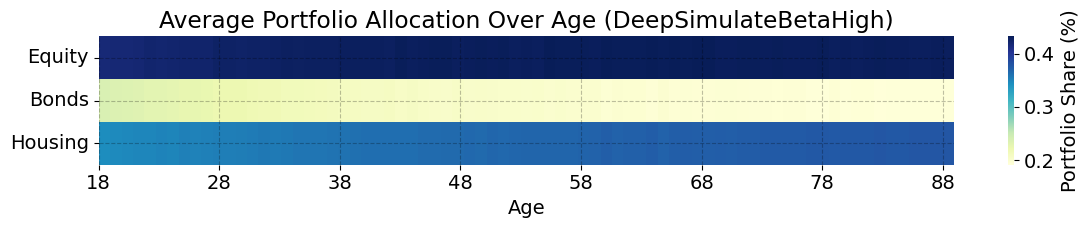

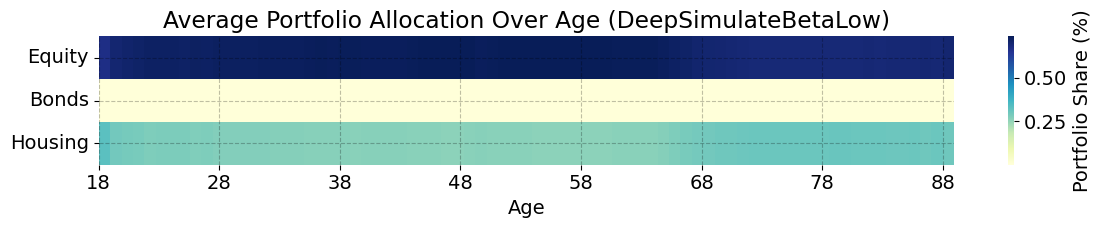

In [12]:
### HEAT MAP FOR Portfolio Allocation
# Extract actions (assumes model_key is defined, e.g., 'DeepSimulateBetaHigh')
for model_key, label in model_DL.items():
    actions = model_DL[model_key].sim.actions.cpu().numpy()
    
    # Asset allocations: equity (2), bonds (3), housing (4)
    equity = actions[:, :, 2]
    bonds  = actions[:, :, 3]
    house  = actions[:, :, 4]
    
    # Total assets (avoid division by zero)
    total_asset = equity + bonds + house + 1e-8
    
    # Compute average shares across individuals (axis=1)
    equity_share = np.mean(equity / total_asset, axis=1)
    bond_share   = np.mean(bonds  / total_asset, axis=1)
    house_share  = np.mean(house  / total_asset, axis=1)
    
    # Stack for heatmap (3 x T)
    share_matrix = np.vstack([equity_share, bond_share, house_share])
    
    # Plot
    plt.figure(figsize=(12, 2.5))
    sns.heatmap(share_matrix, cmap='YlGnBu', cbar_kws={'label': 'Portfolio Share (%)'},
                xticklabels=10, yticklabels=['Equity', 'Bonds', 'Housing'])
    
    plt.title(f"Average Portfolio Allocation Over Age ({model_key})")
    plt.xlabel("Age")
    plt.xticks(np.linspace(0, 74, 8), labels=[str(age) for age in range(18, 93, 10)], rotation=0)
    plt.tight_layout()
    plt.show()
